In [ ]:
# This calculates the difference in absolute magnitudes of a planet with and
# without atmospheric transmission correction. The purpose is to quantify the
# color error introduced by wavelength-variable atmospheric transmission

# Created 2020 Apr. 30 by E.S.

# For the math, see research notebook fizeau_altair.tex on date 2020 Apr. 13

In [ ]:
#########################################################################
### !!!!!  THIS NOTEBOOK HAS BEEN SUPERCEDED BY COLOR_ERROR_V2  !!!!!
#########################################################################

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import pysynphot as S

%matplotlib inline

# Needed ingredients

### The equation we want to solve is
### $M_{pl}^{(N)} - M_{pl}^{(T)} 
=  2.5\textrm{log}_{10} \left\{ 
	\frac{
	\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda,pl}^{(0)} 
	}{
	\int d\lambda R_{\lambda} f_{\lambda,pl}^{(0)} 
	}  
	\frac{
		\int d\lambda R_{\lambda}f_{\lambda,Vega}^{(0)}
		}
		{
		\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda,Vega}^{(0)}
		}
	\right\}$
### or in terms of code variables,
$M\_diff
=  2.5\textrm{log}_{10} \left\{ 
	\frac{
	\textrm{piece1} 
	}{
	\textrm{piece2}
	}  
	\frac{
	\textrm{piece3}
	}
	{
	\textrm{piece4}
	}
	\right\}$
### where
### $M_{pl}^{(N)}$: absolute magnitude of a planet with NO atmospheric transmission effects
### $M_{pl}^{(T)}$ expected calculated absolute magnitude of a planet WITH atmospheric transmission effects
### $R_{\lambda}$: filter response curve
### $T_{\lambda}$: atmospheric transmission
### $f_{\lambda,Vega}^{(0)}$: flux of Vega at the top of the Earth's atmosphere
### $f_{\lambda,pl}^{(0)}$: flux of a planet at the top of the Earth's atmosphere

# Read in data

### Read in filter curve

In [4]:
# Naco NB405 filter

nb405_transmission = pd.read_csv("data/Paranal_NACO.NB405.dat.txt", 
                                 names=["wavel_angs", "transmission"], delim_whitespace=True)

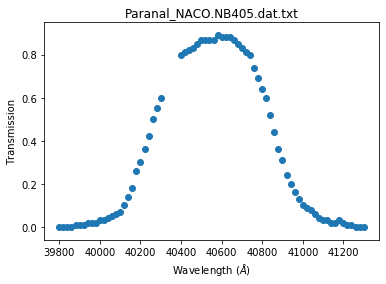

In [5]:
# plot filter

plt.clf()
plt.scatter(nb405_transmission["wavel_angs"],nb405_transmission["transmission"])
plt.title("Paranal_NACO.NB405.dat.txt")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Transmission")
plt.show()

### Read in model spectra of planets

In [6]:
# Read in blackbodies in the general range of relevant temperatures of planets
# (note these are BB emissions at their surfaces)
# Ref: research journal, 2020 Mar. 4

bb_00200K = pd.read_csv("data/bb00200.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)
bb_00400K = pd.read_csv("data/bb00400.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)
bb_00650K = pd.read_csv("data/bb00650.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)
bb_02800K = pd.read_csv("data/bb02800.dat.txt",
                                 names=["wavel_angs", "flux"], skiprows=6, delim_whitespace=True)

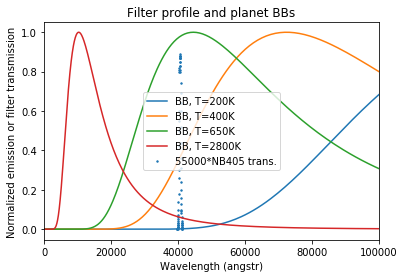

In [7]:
# plot planet BBs

plt.clf()
plt.plot(bb_00200K["wavel_angs"],np.divide(bb_00200K["flux"],np.max(bb_00200K["flux"])),
         label="BB, T=200K")
plt.plot(bb_00400K["wavel_angs"],np.divide(bb_00400K["flux"],np.max(bb_00400K["flux"])),
         label="BB, T=400K")
plt.plot(bb_00650K["wavel_angs"],np.divide(bb_00650K["flux"],np.max(bb_00650K["flux"])),
         label="BB, T=650K")
plt.plot(bb_02800K["wavel_angs"],np.divide(bb_02800K["flux"],np.max(bb_02800K["flux"])),
         label="BB, T=2800K")
plt.scatter(nb405_transmission["wavel_angs"],nb405_transmission["transmission"],s=2,
            label="55000*NB405 trans.")
plt.title("Filter profile and planet BBs")
plt.xlabel("Wavelength (angstr)")
plt.ylabel("Normalized emission or filter transmission")
plt.xlim([0,1e5])
plt.legend()
plt.show()

### Obtain spectrum of Vega

In [8]:
# Vega spectrum is imported from pysynphot
# refs: 
# https://pysynphot.readthedocs.io
# https://www.stsci.edu/itt/review/synphot_2007/AppA_Catalogsa2.html

print("Vega flux units are")
print(S.Vega.fluxunits.name)

# flam = erg s−1 cm−2 \AA−1 (which is what I want! and at this amplitude it must be the flux at Earth)

Vega flux units are
flam


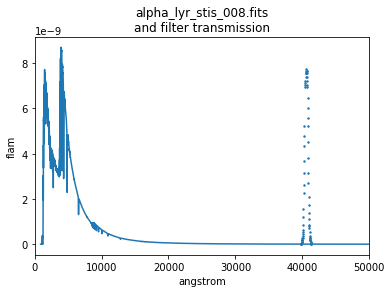

In [9]:
plt.clf()
plt.plot(S.Vega.wave, S.Vega.flux)
plt.scatter(nb405_transmission["wavel_angs"],np.max(S.Vega.flux)*nb405_transmission["transmission"],s=2,
            label="NB405 trans.")
plt.xlim(0, 50000)
plt.xlabel(S.Vega.waveunits)
plt.ylabel(S.Vega.fluxunits)
plt.title(os.path.basename(S.Vega.name) + "\nand filter transmission")
plt.show()

### Read in atmospheric transmission

In [10]:
# For considering airmass and PWV transmission effects, here are plots of transmission

# source: https://atran.arc.nasa.gov/cgi-bin/atran/atran.cgi

# INPUT PARAMS for atran.plt.12172.dat:
'''
Altitude    :    10567.0000    
 Water Vapor :    11.0000000    
 Num layers  :            2
 Zenith Angle:    30.0000000    
 Obs Lat     :    30.0000000    
 Minimum Wave:    3.98000002    
 Maximum Wave:    4.13000011   
'''

trans_df = pd.read_csv("data/atran.plt.12172.dat", usecols=[1,2], 
                       names=["wavel_um","transmission"], delim_whitespace=True)
# add column of wavelength in angstroms
trans_df["wavel_angs"] = (1e4)*trans_df["wavel_um"]

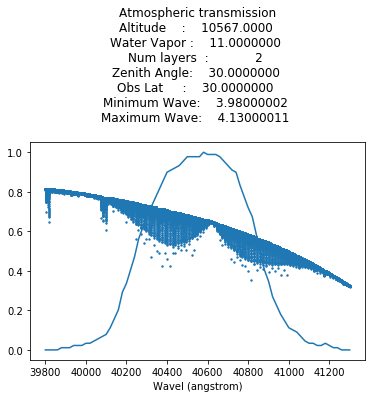

In [11]:
# plot

plt.scatter(trans_df["wavel_angs"],trans_df["transmission"],s=2,label="55000* Atm. trans.")
plt.plot(nb405_transmission["wavel_angs"],
         np.divide(nb405_transmission["transmission"],np.max(nb405_transmission["transmission"])),label="NB405 trans.")
plt.title("Atmospheric transmission\n" + \
"Altitude    :    10567.0000 \n" + \
"Water Vapor :    11.0000000 \n" + \
"Num layers  :            2 \n" + \
"Zenith Angle:    30.0000000 \n" + \
"Obs Lat     :    30.0000000 \n" + \
"Minimum Wave:    3.98000002 \n" + \
"Maximum Wave:    4.13000011 \n")
plt.xlabel("Wavel (angstrom)")
plt.show()

# Calculate pieces

## Interpolate all the curves (blackbodies, Altair, atmosphere) so that they and the abcissa of
## the filter transmission are the same

In [34]:
# To do the integration over two functions represented by input arrays, use the abcissa
# of the filter transmission $R$ to make an interpolated form of $f$ pinned to the same 
# ordinate. Then multiply the two arrays together and integrate over that.

'''
Choices of objects are blackbodies:

bb_00200K
bb_00400K
bb_00650K
bb_02800K
'''

# blackbody fluxes at the surface of the blackbody
bb_00200K_surf_flux_filter = np.interp(nb405_transmission["wavel_angs"].values, 
                                             bb_00200K["wavel_angs"].values,
                                             bb_00200K["flux"].values)

bb_00400K_surf_flux_filter = np.interp(nb405_transmission["wavel_angs"].values, 
                                             bb_00400K["wavel_angs"].values,
                                             bb_00400K["flux"].values)

bb_00650K_surf_flux_filter = np.interp(nb405_transmission["wavel_angs"].values, 
                                             bb_00650K["wavel_angs"].values,
                                             bb_00650K["flux"].values)

bb_02800K_surf_flux_filter = np.interp(nb405_transmission["wavel_angs"].values, 
                                             bb_02800K["wavel_angs"].values,
                                             bb_02800K["flux"].values)

vega_earth_flux_filter = np.interp(nb405_transmission["wavel_angs"].values, 
                                             S.Vega.wave,
                                             S.Vega.flux)

atm_transmission_filter = np.interp(nb405_transmission["wavel_angs"].values,
                                    trans_df["wavel_angs"],
                                    trans_df["transmission"])

In [30]:
# plot an example

plt.clf()
plt.scatter(bb_00200K["wavel_angs"].values,bb_00200K["flux"].values,label="original")
plt.plot(nb405_transmission["wavel_angs"].values,bb_00200K_surf_flux_filter,color="r",label="interpolated")
plt.legend()
plt.xlim([39000,42000]) # area of filter transmission
plt.show()

## Define the pieces

## piece1
### Integration of object flux, atmospheric transmission, and filter response (let's leave arguments $(\lambda)$ off for simplicity): 
### $\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda}^{(0, obj)} = \left( \frac{R_{obj}}{D} \right)^{2}\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda}^{(surf, obj)} $
### However, the scaling factor $\left( \frac{R_{obj}}{D} \right)^{2}$ cancels in the fractions that go into the logarithm we want to calculate, so let's just calculate a quantity we call 
## piece1_unscaled:
### $\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda}^{(surf, obj)} $

## piece2
### Integration of object flux and filter response
### $\int d\lambda R_{\lambda} f_{\lambda}^{(0, obj)} = \left( \frac{R_{obj}}{D} \right)^{2}\int d\lambda R_{\lambda} f_{\lambda}^{(surf, obj)} $
### Again, removing the scaling factor which cancels anyway, we calculate
## piece2_unscaled:
### $\int d\lambda R_{\lambda} f_{\lambda}^{(surf, obj)} $

## piece3
### Integration of Vega flux and filter response
### $\int d\lambda R_{\lambda} f_{\lambda}^{(0, Vega)} = \left( \frac{R_{obj}}{D} \right)^{2}\int d\lambda R_{\lambda} f_{\lambda}^{(surf, Vega)} $
### Removing the scaling factor,
## piece3_unscaled:
### $\int d\lambda R_{\lambda} f_{\lambda}^{(surf, Vega)} $

## piece4
### Integration of Vega flux, atmospheric transmission, and filter response (let's leave arguments $(\lambda)$ off for simplicity): 
### $\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda}^{(0, Vega)} = \left( \frac{R_{Vega}}{D} \right)^{2}\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda}^{(surf, Vega)} $
### Removing the scaling factor,
## piece4_unscaled:
### $\int d\lambda R_{\lambda} T_{\lambda} f_{\lambda}^{(surf, Vega)} $

## Calculate the pieces

In [40]:
# calculate R*f integrands

integrand_unscaled_R_times_f_00200K = np.multiply(bb_00200K_surf_flux_filter,nb405_transmission["transmission"])
integrand_unscaled_R_times_f_00400K = np.multiply(bb_00400K_surf_flux_filter,nb405_transmission["transmission"])
integrand_unscaled_R_times_f_00650K = np.multiply(bb_00650K_surf_flux_filter,nb405_transmission["transmission"])
integrand_unscaled_R_times_f_02800K = np.multiply(bb_02800K_surf_flux_filter,nb405_transmission["transmission"])

# vega flux is already 'scaled' for distance because it's the value of the flux at Earth
integrand_scaled_R_times_flux_vega = np.multiply(vega_earth_flux_filter,nb405_transmission["transmission"])

In [41]:
# calculate R*T*f integrands

integrand_unscaled_R_times_T_times_f_00200K = np.multiply(atm_transmission_filter,integrand_unscaled_R_times_f_00200K)
integrand_unscaled_R_times_T_times_f_00400K = np.multiply(atm_transmission_filter,integrand_unscaled_R_times_f_00400K)
integrand_unscaled_R_times_T_times_f_00650K = np.multiply(atm_transmission_filter,integrand_unscaled_R_times_f_00650K)
integrand_unscaled_R_times_T_times_f_02800K = np.multiply(atm_transmission_filter,integrand_unscaled_R_times_f_02800K)

# vega flux is already 'scaled' for distance because it's the value of the flux at Earth
integrand_scaled_R_times_T_times_flux_vega = np.multiply(atm_transmission_filter,integrand_scaled_R_times_flux_vega)

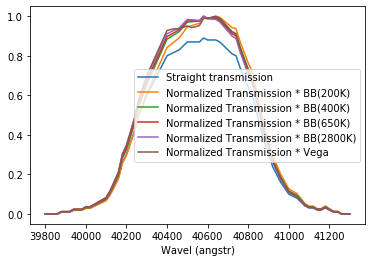

In [46]:
# plot R*f integrands

plt.clf()
plt.plot(nb405_transmission["wavel_angs"],nb405_transmission["transmission"], label="Straight transmission")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_f_00200K,np.max(integrand_unscaled_R_times_f_00200K)), 
         label="Normalized Transmission * BB(200K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_f_00400K,np.max(integrand_unscaled_R_times_f_00400K)), 
         label="Normalized Transmission * BB(400K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_f_00650K,np.max(integrand_unscaled_R_times_f_00650K)), 
         label="Normalized Transmission * BB(650K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_f_02800K,np.max(integrand_unscaled_R_times_f_02800K)), 
         label="Normalized Transmission * BB(2800K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_scaled_R_times_flux_vega,np.max(integrand_scaled_R_times_flux_vega)), 
         label="Normalized Transmission * Vega")
plt.xlabel("Wavel (angstr)")
plt.legend()
plt.show()

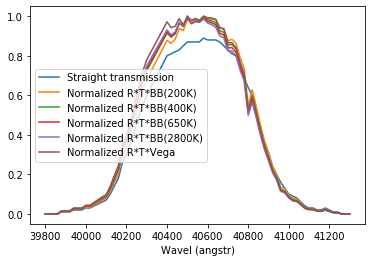

In [47]:
# plot R*T*f integrands

plt.clf()
plt.plot(nb405_transmission["wavel_angs"],nb405_transmission["transmission"], label="Straight transmission")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_T_times_f_00200K,np.max(integrand_unscaled_R_times_T_times_f_00200K)), 
         label="Normalized R*T*BB(200K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_T_times_f_00400K,np.max(integrand_unscaled_R_times_T_times_f_00400K)), 
         label="Normalized R*T*BB(400K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_T_times_f_00650K,np.max(integrand_unscaled_R_times_T_times_f_00650K)), 
         label="Normalized R*T*BB(650K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_unscaled_R_times_T_times_f_02800K,np.max(integrand_unscaled_R_times_T_times_f_02800K)), 
         label="Normalized R*T*BB(2800K)")
plt.plot(nb405_transmission["wavel_angs"],np.divide(integrand_scaled_R_times_T_times_flux_vega,np.max(integrand_scaled_R_times_T_times_flux_vega)), 
         label="Normalized R*T*Vega")
plt.xlabel("Wavel (angstr)")
plt.legend()
plt.show()

In [48]:
# integrate 

piece_1_unscaled_00200K = np.trapz(integrand_unscaled_R_times_T_times_f_00200K,x=nb405_transmission["wavel_angs"])
piece_1_unscaled_00400K = np.trapz(integrand_unscaled_R_times_T_times_f_00400K,x=nb405_transmission["wavel_angs"])
piece_1_unscaled_00650K = np.trapz(integrand_unscaled_R_times_T_times_f_00650K,x=nb405_transmission["wavel_angs"])
piece_1_unscaled_02800K = np.trapz(integrand_unscaled_R_times_T_times_f_02800K,x=nb405_transmission["wavel_angs"])

piece_2_unscaled_00200K = np.trapz(integrand_unscaled_R_times_f_00200K,x=nb405_transmission["wavel_angs"])
piece_2_unscaled_00400K = np.trapz(integrand_unscaled_R_times_f_00400K,x=nb405_transmission["wavel_angs"])
piece_2_unscaled_00650K = np.trapz(integrand_unscaled_R_times_f_00650K,x=nb405_transmission["wavel_angs"])
piece_2_unscaled_02800K = np.trapz(integrand_unscaled_R_times_f_02800K,x=nb405_transmission["wavel_angs"])

piece_3_scaled_vega = np.trapz(integrand_scaled_R_times_flux_vega,x=nb405_transmission["wavel_angs"])
piece_4_scaled_vega = np.trapz(integrand_scaled_R_times_T_times_flux_vega,x=nb405_transmission["wavel_angs"])

# Put pieces together

In [49]:
M_diff_00200K = np.log10(np.divide(piece_1_unscaled_00200K,piece_2_unscaled_00200K)*
                         np.divide(piece_3_scaled_vega,piece_4_scaled_vega))
M_diff_00400K = np.log10(np.divide(piece_1_unscaled_00400K,piece_2_unscaled_00400K)*
                         np.divide(piece_3_scaled_vega,piece_4_scaled_vega))
M_diff_00650K = np.log10(np.divide(piece_1_unscaled_00650K,piece_2_unscaled_00650K)*
                         np.divide(piece_3_scaled_vega,piece_4_scaled_vega))
M_diff_02800K = np.log10(np.divide(piece_1_unscaled_02800K,piece_2_unscaled_02800K)*
                         np.divide(piece_3_scaled_vega,piece_4_scaled_vega))

In [52]:
print("M_diff_00200K:")
print(M_diff_00200K)
print("M_diff_00400K:")
print(M_diff_00400K)
print("M_diff_00650K:")
print(M_diff_00650K)
print("M_diff_02800K:")
print(M_diff_02800K)

M_diff_00200K:
-0.0035059435745703822
M_diff_00400K:
-0.0013594710347566356
M_diff_00650K:
-0.0005449095769895766
M_diff_02800K:
0.0003448828694754202
